# Credit card fraud detection

This notebook will test fraud detection method using deep autoencoder. 


### Using Auto Encoders for Anomaly Detection

The idea to apply it to anomaly detection is very straightforward:

- train an auto-encoder on X_train with good regularization

- evaluate it on the validation set X_val and visualise the reconstructed error plot 

- choose a threshold  which determines whether a value is an outlier (anomalies) or not


http://ufldl.stanford.edu/tutorial/unsupervised/Autoencoders/

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
try:
    data = pd.read_csv("../input/creditcard.csv")
except Exception as e:
    data = pd.read_csv("/Users/serdar/Documents/data/creditcard.csv")
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Text(0, 0.5, 'Frequency')

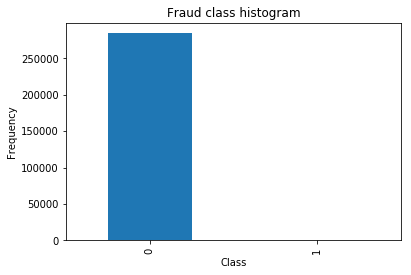

In [3]:
count_classes = pd.value_counts(data['Class'], sort = True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("Fraud class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")

In [4]:
from sklearn.preprocessing import StandardScaler

data['normAmount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

# hour = data['Time'].apply(lambda x: np.ceil(float(x)/3600) % 24)
# data['hour'] = StandardScaler().fit_transform(hour.reshape(-1, 1))

data = data.drop(['Time','Amount'],axis=1)
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,normAmount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403


# Autoencoder

In [5]:
class Autoencoder(object):

    def __init__(self, n_hidden_1, n_hidden_2, n_input, learning_rate):
        self.n_hidden_1 = n_hidden_1
        self.n_hidden_2 = n_hidden_2
        self.n_input = n_input

        self.learning_rate = learning_rate

        self.weights, self.biases = self._initialize_weights()

        self.x = tf.placeholder("float", [None, self.n_input])

        self.encoder_op = self.encoder(self.x)
        self.decoder_op = self.decoder(self.encoder_op)

        self.cost = tf.reduce_mean(tf.pow(self.x - self.decoder_op, 2))
        self.optimizer = tf.train.RMSPropOptimizer(self.learning_rate).minimize(self.cost)

        init = tf.initialize_all_variables()
        self.sess = tf.Session()
        self.sess.run(init)

    def _initialize_weights(self):
        weights = {
            'encoder_h1': tf.Variable(tf.random_normal([self.n_input, self.n_hidden_1])),
            'encoder_h2': tf.Variable(tf.random_normal([self.n_hidden_1, self.n_hidden_2])),
            'decoder_h1': tf.Variable(tf.random_normal([self.n_hidden_2, self.n_hidden_1])),
            'decoder_h2': tf.Variable(tf.random_normal([self.n_hidden_1, self.n_input])),
        }
        biases = {
            'encoder_b1': tf.Variable(tf.random_normal([self.n_hidden_1])),
            'encoder_b2': tf.Variable(tf.random_normal([self.n_hidden_2])),
            'decoder_b1': tf.Variable(tf.random_normal([self.n_hidden_1])),
            'decoder_b2': tf.Variable(tf.random_normal([self.n_input])),
        }

        return weights, biases

    def encoder(self, X):
        layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(X, self.weights['encoder_h1']),
                                       self.biases['encoder_b1']))
        layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, self.weights['encoder_h2']),
                                       self.biases['encoder_b2']))
        return layer_2

    def decoder(self, X):
        layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(X, self.weights['decoder_h1']),
                                       self.biases['decoder_b1']))
        layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, self.weights['decoder_h2']),
                                       self.biases['decoder_b2']))
        return layer_2

    def calc_total_cost(self, X):
        return self.sess.run(self.cost, feed_dict={self.x: X})

    def partial_fit(self, X):
        cost, opt = self.sess.run((self.cost, self.optimizer), feed_dict={self.x: X})
        return cost

    def transform(self, X):
        return self.sess.run(self.encoder_op, feed_dict={self.x: X})

    def reconstruct(self, X):
        return self.sess.run(self.decoder_op, feed_dict={self.x: X})

## Train test split

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
good_data = data[data['Class'] == 0]
bad_data = data[data['Class'] == 1]
#print 'bad: {}, good: {}'.format(len(bad_data), len(good_data))

In [9]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=42)

X_train = X_train[X_train['Class']==0]
X_train = X_train.drop(['Class'], axis=1)

y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

X_train = X_train.values
X_test = X_test.values

In [10]:
X_good = good_data.ix[:, good_data.columns != 'Class']
y_good = good_data.ix[:, good_data.columns == 'Class']

X_bad = bad_data.ix[:, bad_data.columns != 'Class']
y_bad = bad_data.ix[:, bad_data.columns == 'Class']

/Users/serdar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  
/Users/serdar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/serdar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """


## Model

In [11]:
model = Autoencoder(n_hidden_1=15, n_hidden_2=3, n_input=X_train.shape[1], learning_rate = 0.01)

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [12]:
training_epochs = 100
batch_size = 256
display_step = 100
record_step = 10

## Train

In [13]:
total_batch = int(X_train.shape[0]/batch_size)

cost_summary = []

for epoch in range(training_epochs):
    cost = None
    for i in range(total_batch):
        batch_start = i * batch_size
        batch_end = (i + 1) * batch_size
        batch = X_train[batch_start:batch_end, :]
        
        cost = model.partial_fit(batch)
    
    if epoch % display_step == 0 or epoch % record_step == 0:
        total_cost = model.calc_total_cost(X_train)
        
        if epoch % record_step == 0:
            cost_summary.append({'epoch': epoch+1, 'cost': total_cost})
        
        if epoch % display_step == 0:
            print("Epoch:{}, cost={:.9f}".format(epoch+1, total_cost))

Epoch:1, cost=0.911785424


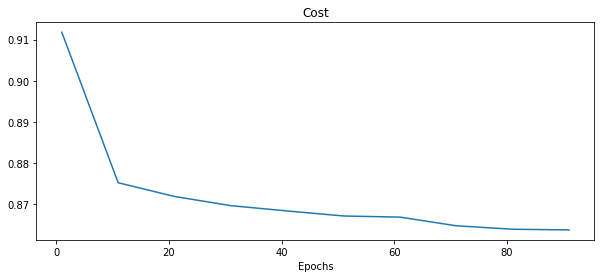

In [14]:
f, ax1 = plt.subplots(1, 1, figsize=(10,4))

ax1.plot(list(map(lambda x: x['epoch'], cost_summary)), list(map(lambda x: x['cost'], cost_summary)))
ax1.set_title('Cost')

plt.xlabel('Epochs')
plt.show()

## Test

In [15]:
encode_decode = None
total_batch = int(X_test.shape[0]/batch_size) + 1
for i in range(total_batch):
    batch_start = i * batch_size
    batch_end = (i + 1) * batch_size
    batch = X_test[batch_start:batch_end, :]
    batch_res = model.reconstruct(batch)
    if encode_decode is None:
        encode_decode = batch_res
    else:
        encode_decode = np.vstack((encode_decode, batch_res))

In [16]:
def get_df(orig, ed, _y):
    rmse = np.mean(np.power(orig - ed, 2), axis=1)
    return pd.DataFrame({'rmse': rmse, 'target': _y})

In [17]:
df = get_df(X_test, encode_decode, y_test)

In [18]:
df.describe()

,rmse,target
count,56962.000000,56962.000000
mean,0.894200,0.001720
std,3.734108,0.041443
min,0.083492,0.000000
25%,0.298302,0.000000
50%,0.472904,0.000000
75%,0.760209,0.000000
max,261.198864,1.000000


## Reconstruction error without fraud

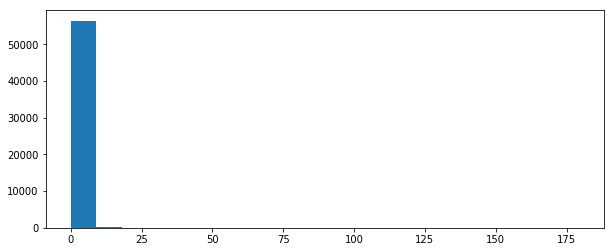

In [19]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
_ = ax.hist(df[df['target']== 0].rmse.values, bins=20)

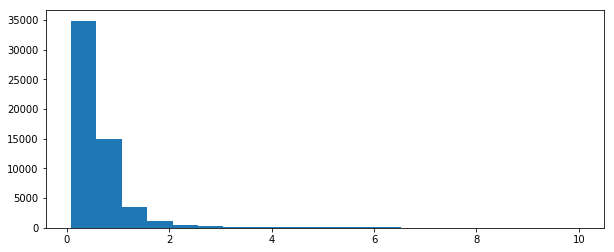

In [20]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
_ = ax.hist(df[(df['target']== 0) & (df['rmse'] < 10)].rmse.values, bins=20)

## Reconstruction error with fraud

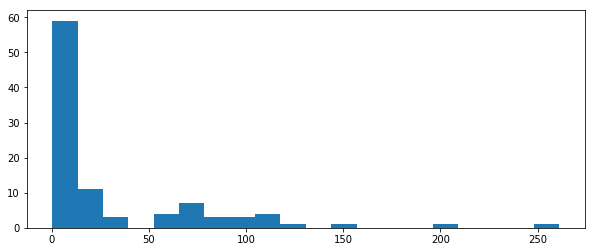

In [21]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
_ = ax.hist(df[df['target'] > 0].rmse.values, bins=20)

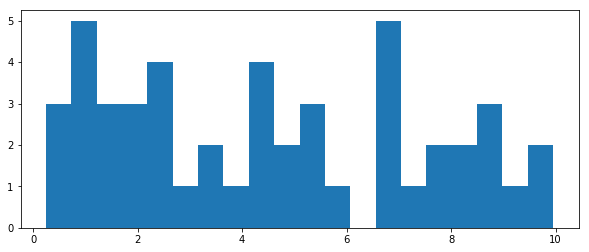

In [22]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
_ = ax.hist(df[(df['target'] > 0) & (df['rmse'] < 10)].rmse.values, bins=20)

## Metrics

In [23]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc, roc_auc_score, 
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support) 

In [24]:
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else:
        1

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### ROC AUC

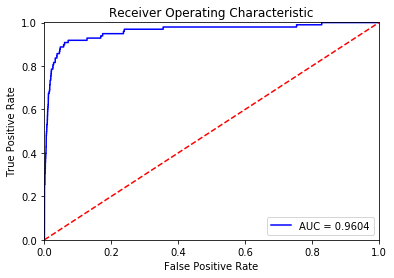

In [25]:
fpr, tpr, thresholds = roc_curve(df.target, df.rmse)
roc_auc = auc(fpr,tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

ROC AUC seems not bad. But we know that it is highly imbalanced dataset. So let's see precision-recall.

### Precision-Recall

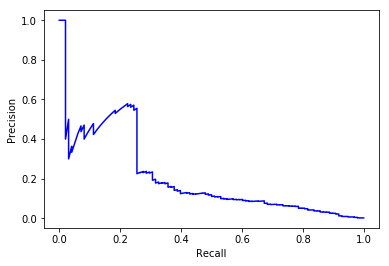

In [26]:
precision, recall, th = precision_recall_curve(df.target, df.rmse)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

Now its clear that our classifier is not so good.
ROC curve is not a good visual illustration for highly imbalanced data.
Because the False Positive Rate ( False Positives / Total Real Negatives ) does not drop drastically when the Total Real Negatives is huge. 
Whereas Precision ( True Positives / (True Positives + False Positives) ) is highly sensitive to False Positives and is not impacted by a large total real negative denominator.

This autoencoder classifier can obtain good recall but with very low precision. 

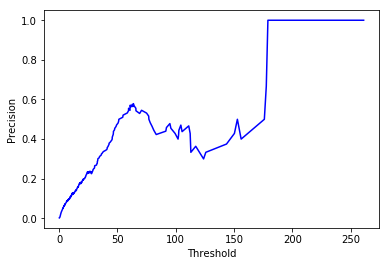

In [27]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

### Confusion matrix

Recall metric in the testing dataset:  0.8571428571428571


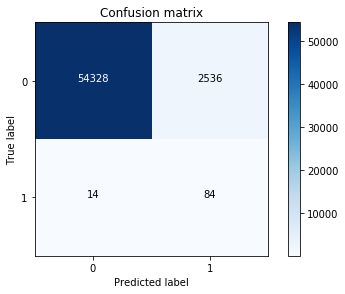

In [28]:
# Compute confusion marix
y_pred = [1 if p > 2 else 0 for p in df.rmse.values]
cnf_matrix = confusion_matrix(df.target, y_pred)
np.set_printoptions(precision=2)

print("Recall metric in the testing dataset: ", float(cnf_matrix[1,1])/(cnf_matrix[1,0]+cnf_matrix[1,1]))

class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix')
plt.show()

In [29]:
f1_score(y_pred=y_pred, y_true=df.target)

0.06181015452538632

In [30]:
precision_recall_fscore_support(y_pred=y_pred, y_true=df.target)

(array([1.  , 0.03]),
 array([0.96, 0.86]),
 array([0.98, 0.06]),
 array([56864,    98]))